In [0]:
import os
import json
from functools import *
import requests
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import plotnine as p9
from adjustText import adjust_text
import plotnine as p9

In [0]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=660f3c52afb734c94e90aaffc045edbf36a19265ec739d3b6137a74a932c14c5
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# os = 0
# params = {'$limit': 1000, '$offset': os}
# response = requests.get('https://data.cityofchicago.org/resource/m6dm-c72p.json?$where=trip_start_timestamp%20between%20%272019-05-01T00:00:00%27%20and%20%272019-06-01T00:00:00%27', params).json()
# total_response = response
# os = 1000
# i = 1
# while len(response) >= 1000:
#     if os % 500000 == 0:
#       df = pd.DataFrame.from_dict(total_response)
#       df.to_csv(f'/content/drive/My Drive/tnp_pagerank/tnp_may2019_{i}.csv')
#       i += 1
#       total_response = []
#     params = {'$limit': 1000, '$offset': os}
#     response = requests.get('https://data.cityofchicago.org/resource/m6dm-c72p.json?$where=trip_start_timestamp%20between%20%272019-05-01T00:00:00%27%20and%20%272019-06-01T00:00:00%27', params).json()
#     os += 1000
#     total_response += response

In [0]:
count_df_lst = []
folder = "/content/drive/My Drive/Math ML project/tnp_pagerank/train_data"
for csv in os.listdir(folder):
  one_csv_df = pd.read_csv(f"{folder}/{csv}", index_col=0)
  community_area_cols = ['pickup_community_area', 'dropoff_community_area']
  one_csv_df.dropna(subset=community_area_cols, inplace=True)
  for col in community_area_cols:
    one_csv_df[col] = one_csv_df[col].astype(int)
    one_csv_df[col] = one_csv_df[col].astype(str)
  one_csv_df['pickup_dropoff'] = one_csv_df['pickup_community_area'] + '_' + one_csv_df['dropoff_community_area']
  count_df = pd.DataFrame({'count': one_csv_df.groupby('pickup_dropoff').size()}).reset_index()
  count_df_lst.append(count_df)
total_count_df = reduce(lambda x, y: pd.merge(x, y, on=['pickup_dropoff'], how='outer'), count_df_lst)

In [0]:
big_df_lst = []
folder = "/content/drive/My Drive/Math ML project/tnp_pagerank/train_data"
for csv in os.listdir(folder):
  one_csv_df = pd.read_csv(f"{folder}/{csv}", index_col=0)
  community_area_cols = ['pickup_community_area', 'dropoff_community_area']
  one_csv_df.dropna(subset=community_area_cols, inplace=True)
  big_df_lst.append(one_csv_df)
big_df = pd.concat(big_df_lst)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [0]:
grouped_lst = []
for col in ['pickup_community_area', 'dropoff_community_area']:
  grouped = pd.DataFrame(big_df.groupby(col).size()).reset_index().rename(columns={0: f'{col[:-15]}_count', col: 'community_area'})
  grouped_lst.append(grouped)
pickup_dropoff_count_df = reduce(lambda x, y: pd.merge(x, y, on=['community_area'], how='outer'), grouped_lst)
pickup_dropoff_count_df.head()

,community_area,pickup_count,dropoff_count
0,1.0,81375,82727
1,2.0,60922,58159
2,3.0,187048,181476
3,4.0,89481,92957
4,5.0,108976,107434


In [0]:
def apply_zone_fn(x):
  if x['zone'] == 'NORTH':
    return 1
  if x['zone'] == 'SOUTH':
    return 2
  if x['zone'] == 'WEST':
    return 3
  return 4

In [0]:
neighborhoods_by_side = pd.read_csv('https://raw.githubusercontent.com/katykoenig/machine-learning-for-public-policy/master/hw1/community-areas.csv')
neighborhoods_by_side = neighborhoods_by_side[['zone', 'id']]
count_w_sides = pickup_dropoff_count_df.merge(neighborhoods_by_side, left_on='community_area', right_on='id')
count_w_sides['zone_int'] = count_w_sides.apply(lambda x: apply_zone_fn(x), axis=1)
count_w_sides.head()

,community_area,pickup_count,dropoff_count,zone,id,zone_int
0,1.0,81375,82727,NORTH,1,1
1,2.0,60922,58159,NORTH,2,1
2,3.0,187048,181476,NORTH,3,1
3,4.0,89481,92957,NORTH,4,1
4,5.0,108976,107434,NORTH,5,1


In [0]:
comm_areas = pd.read_csv('/content/drive/My Drive/Math ML project/chicago-community-areas.csv', index_col=0).T['name']
comm_names_dict = comm_areas.to_dict()
count_w_sides['community_area'] = count_w_sides['community_area'].astype(int).astype(str)
count_w_comm_names = count_w_sides.set_index('community_area').T.rename(columns=comm_areas).T.reset_index()
count_w_comm_names.head()

,community_area,pickup_count,dropoff_count,zone,id,zone_int
0,Rogers Park,81375,82727,NORTH,1,1
1,West Ridge,60922,58159,NORTH,2,1
2,Uptown,187048,181476,NORTH,3,1
3,Lincoln Square,89481,92957,NORTH,4,1
4,North Center,108976,107434,NORTH,5,1


In [0]:
melted_comm_names = pd.melt(count_w_comm_names, id_vars=['community_area', 'id',
                                                         'zone_int', 'zone'])
melted_comm_names.rename(columns={'value': 'count'}, inplace=True)

In [0]:
x_scale = np.linspace(melted_comm_names['count'].min(), melted_comm_names['count'].max(), 50000)

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


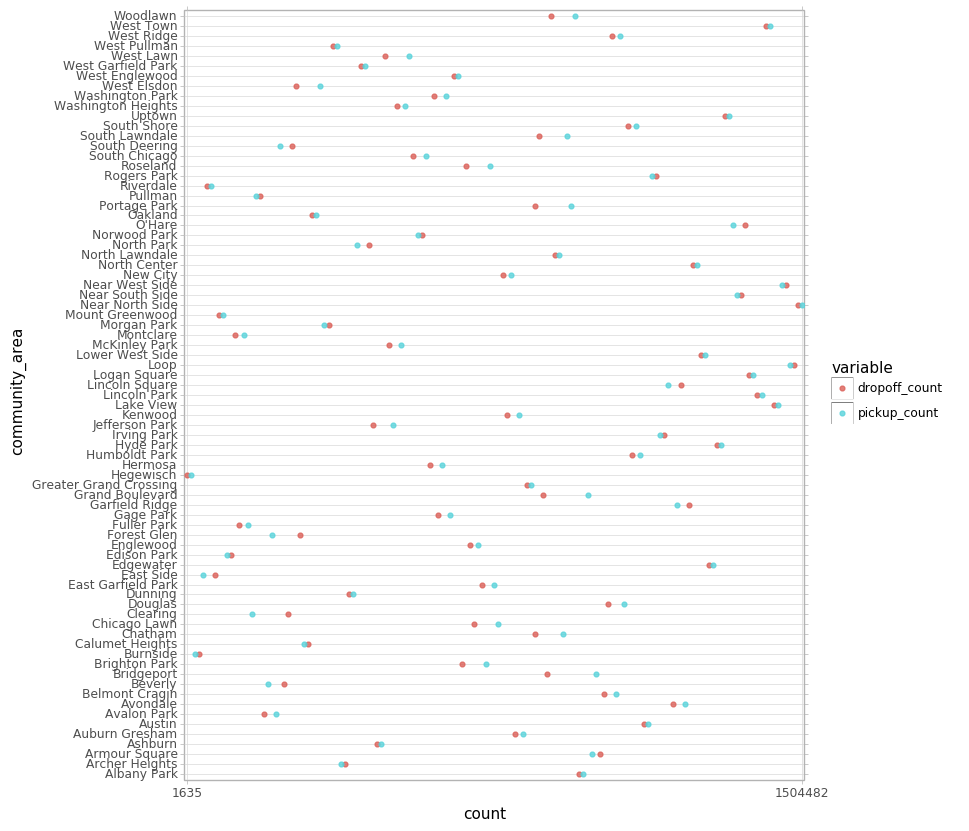

<ggplot: (-9223363250200713356)>

In [0]:
p9.ggplot(melted_comm_names, p9.aes('count', 'community_area')) + \
p9.geom_point(p9.aes(color='variable'), alpha=0.8) + p9.theme_light() + \
p9.theme(figure_size=(8, 10)) + p9.scale_x_discrete(breaks=x_scale)

500

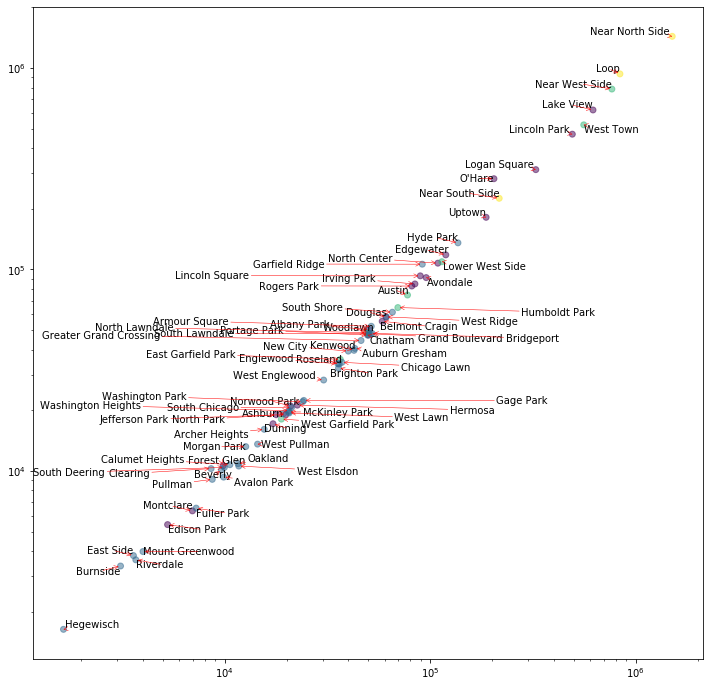

In [0]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(count_w_comm_names['pickup_count'],
            count_w_comm_names['dropoff_count'], alpha=0.5, c=count_w_comm_names['zone_int'])
# x = np.linspace(min(count_w_comm_names['pickup_count']), max(count_w_comm_names['pickup_count']), 500)
# y = np.linspace(min(count_w_comm_names['dropoff_count']), max(count_w_comm_names['dropoff_count']), 500)
# texts = [plt.text(count_w_comm_names['pickup_count'][i],
#                   count_w_comm_names['dropoff_count'][i],
#                   count_w_comm_names['community_area'][i],
#                   ha='center', va='center') for i in range(len(count_w_comm_names['pickup_count']))]
# plt.yscale("log")
# plt.xscale("log")
# adjust_text(texts, x, y, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), only_move={'points':'x', 'text':'x'})

In [0]:
total_count_df.fillna(0, inplace=True)
total_count_df['total_count'] = total_count_df.drop(columns='pickup_dropoff').sum(axis=1)
only_counts_df = total_count_df[['pickup_dropoff', 'total_count']]
only_counts_df[['pickup_dropoff', 'total_count']].to_csv('/content/drive/My Drive/Math ML project/adjacency.csv')

In [0]:
only_counts_df = pd.read_csv('/content/drive/My Drive/Math ML project/adjacency.csv', index_col=0)

In [0]:
only_counts_df['dropoff_area'] = only_counts_df['pickup_dropoff'].str.extract(r'[?<=_](.*)')
only_counts_df['pickup_area'] = only_counts_df['pickup_dropoff'].str.extract(r'(.*)[?<_]')

In [0]:
only_counts_df.head()

,pickup_dropoff,total_count,dropoff_area,pickup_area
0,10_1,200.0,1,10
1,10_10,3544.0,10,10
2,10_11,1424.0,11,10
3,10_12,443.0,12,10
4,10_13,192.0,13,10


In [0]:
col_order = list(map(str, range(1, 78)))
pivoted = only_counts_df.pivot(index='dropoff_area', columns='pickup_area', values='total_count').fillna(0)
ordered_pivot = pivoted[col_order].reindex(col_order)
ordered_pivot.head()

pickup_area,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
dropoff_area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14389.0,7437.0,5759.0,2567.0,1270.0,8286.0,3019.0,8916.0,29.0,200.0,274.0,230.0,781.0,866.0,452.0,783.0,83.0,40.0,220.0,132.0,635.0,1756.0,259.0,1987.0,216.0,42.0,132.0,2673.0,136.0,117.0,324.0,4093.0,551.0,119.0,161.0,30.0,14.0,92.0,92.0,28.0,235.0,103.0,136.0,55.0,4.0,43.0,3.0,9.0,48.0,7.0,3.0,1.0,28.0,1.0,1.0,494.0,15.0,28.0,19.0,93.0,53.0,9.0,14.0,20.0,6.0,44.0,33.0,69.0,68.0,13.0,37.0,5.0,16.0,2.0,10.0,2226.0,9586.0
2,8003.0,9967.0,3326.0,4028.0,1014.0,3101.0,1299.0,3450.0,68.0,328.0,434.0,425.0,2230.0,2040.0,606.0,1076.0,175.0,39.0,439.0,188.0,672.0,973.0,258.0,1015.0,310.0,10.0,69.0,1447.0,118.0,110.0,124.0,2098.0,364.0,74.0,153.0,20.0,9.0,84.0,62.0,8.0,139.0,35.0,66.0,28.0,10.0,48.0,0.0,3.0,17.0,3.0,2.0,3.0,5.0,0.0,2.0,216.0,17.0,51.0,23.0,70.0,33.0,6.0,21.0,3.0,12.0,26.0,25.0,49.0,30.0,11.0,37.0,5.0,10.0,0.0,3.0,1501.0,5435.0
3,5395.0,3655.0,18345.0,7320.0,5262.0,33825.0,12017.0,23839.0,43.0,293.0,625.0,249.0,745.0,2188.0,810.0,3197.0,202.0,66.0,480.0,225.0,2213.0,6500.0,663.0,8106.0,432.0,95.0,299.0,8469.0,187.0,199.0,920.0,11580.0,1548.0,309.0,365.0,70.0,20.0,232.0,257.0,111.0,769.0,225.0,330.0,90.0,26.0,63.0,5.0,30.0,47.0,25.0,14.0,6.0,22.0,8.0,5.0,1140.0,33.0,93.0,86.0,363.0,115.0,18.0,53.0,21.0,32.0,101.0,89.0,80.0,132.0,44.0,72.0,28.0,41.0,7.0,21.0,3826.0,12060.0
4,2481.0,4095.0,7976.0,7879.0,4548.0,12619.0,4250.0,8367.0,76.0,267.0,570.0,324.0,1278.0,2949.0,954.0,3199.0,207.0,40.0,501.0,213.0,1865.0,4528.0,371.0,4101.0,221.0,31.0,109.0,3707.0,56.0,91.0,417.0,4349.0,571.0,134.0,64.0,11.0,28.0,48.0,59.0,13.0,217.0,34.0,77.0,18.0,2.0,6.0,2.0,11.0,6.0,1.0,6.0,2.0,2.0,0.0,0.0,500.0,16.0,50.0,43.0,173.0,50.0,9.0,27.0,11.0,17.0,23.0,17.0,21.0,11.0,4.0,12.0,5.0,4.0,5.0,4.0,2192.0,5812.0
5,1298.0,1100.0,5330.0,4257.0,5239.0,18887.0,8081.0,12704.0,72.0,222.0,236.0,232.0,406.0,1434.0,1019.0,3742.0,210.0,85.0,724.0,338.0,3340.0,7516.0,741.0,6816.0,443.0,100.0,269.0,6134.0,183.0,189.0,570.0,6343.0,673.0,175.0,104.0,27.0,26.0,158.0,140.0,35.0,341.0,84.0,91.0,65.0,6.0,51.0,4.0,12.0,32.0,8.0,0.0,5.0,11.0,6.0,3.0,843.0,32.0,66.0,57.0,197.0,58.0,6.0,31.0,12.0,18.0,54.0,40.0,65.0,66.0,11.0,66.0,11.0,3.0,5.0,10.0,2681.0,2785.0


In [0]:
norm_adj = ordered_pivot / ordered_pivot.sum()
norm_adj

pickup_area,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
dropoff_area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.176823,0.122074,0.030789,0.028688,0.011654,0.013374,0.006144,0.005926,0.005496,0.009543,0.013810,0.023403,0.043839,0.017131,0.009029,0.009290,0.004826,0.005740,0.003767,0.005847,0.006643,0.005379,0.003721,0.003557,0.002785,0.002225,0.003614,0.003493,0.002777,0.002340,0.002844,0.004886,0.002544,0.002302,0.002632,0.002582,0.001926,0.001797,0.002160,0.001168,0.001722,0.002055,0.002077,0.001110,0.000405,0.002033,0.000963,0.000849,0.001330,0.000804,0.000301,0.000278,0.001937,0.000270,0.000608,0.005398,0.000963,0.000782,0.000927,0.001785,0.001326,0.000768,0.000577,0.002328,0.000291,0.001183,0.001089,0.001941,0.001475,0.000673,0.000861,0.000519,0.000777,0.000499,0.000790,0.010900,0.080513
2,0.098347,0.163603,0.017782,0.045015,0.009305,0.005005,0.002644,0.002293,0.012886,0.015651,0.021875,0.043244,0.125175,0.040354,0.012105,0.012766,0.010176,0.005596,0.007517,0.008328,0.007030,0.002981,0.003707,0.001817,0.003997,0.000530,0.001889,0.001891,0.002410,0.002200,0.001088,0.002504,0.001680,0.001432,0.002501,0.001721,0.001238,0.001641,0.001455,0.000334,0.001018,0.000698,0.001008,0.000565,0.001012,0.002269,0.000000,0.000283,0.000471,0.000345,0.000201,0.000834,0.000346,0.000000,0.001217,0.002360,0.001091,0.001424,0.001122,0.001343,0.000826,0.000512,0.000865,0.000349,0.000582,0.000699,0.000825,0.001379,0.000651,0.000570,0.000861,0.000519,0.000485,0.000000,0.000237,0.007350,0.045648
3,0.066298,0.059995,0.098076,0.081805,0.048286,0.054596,0.024455,0.015845,0.008149,0.013981,0.031502,0.025336,0.041819,0.043281,0.016180,0.037930,0.011746,0.009471,0.008219,0.009967,0.023151,0.019912,0.009525,0.014512,0.005570,0.005033,0.008186,0.011066,0.003819,0.003979,0.008074,0.013823,0.007147,0.005979,0.005967,0.006025,0.002752,0.004532,0.006033,0.004630,0.005634,0.004488,0.005040,0.001816,0.002631,0.002978,0.001605,0.002829,0.001302,0.002872,0.001405,0.001667,0.001522,0.002164,0.003041,0.012456,0.002118,0.002597,0.004195,0.006966,0.002878,0.001537,0.002184,0.002444,0.001552,0.002716,0.002936,0.002251,0.002864,0.002278,0.001675,0.002904,0.001990,0.001748,0.001658,0.018735,0.101292
4,0.030488,0.067217,0.042641,0.088052,0.041734,0.020368,0.008649,0.005561,0.014402,0.012740,0.028730,0.032967,0.071737,0.058335,0.019057,0.037954,0.012037,0.005740,0.008578,0.009436,0.019511,0.013871,0.005330,0.007342,0.002849,0.001642,0.002984,0.004844,0.001144,0.001820,0.003660,0.005191,0.002636,0.002593,0.001046,0.000947,0.003853,0.000938,0.001385,0.000542,0.001590,0.000678,0.001176,0.000363,0.000202,0.000284,0.000642,0.001037,0.000166,0.000115,0.000602,0.000556,0.000138,0.000000,0.000000,0.005463,0.001027,0.001396,0.002097,0.003320,0.001251,0.000768,0.001113,0.001280,0.000825,0.000619,0.000561,0.000591,0.000239,0.000207,0.000279,0.000519,0.000194,0.001248,0.000316,0.010734,0.048815
5,0.015951,0.018056,0.028495,0.047574,0.048075,0.030485,0.016445,0.008444,0.013644,0.010593,0.011895,0.023606,0.022790,0.028366,0.020355,0.044396,0.012211,0.012197,0.012396,0.014973,0.034941,0.023024,0.010646,0.012203,0.005712,0.005298,0.007364,0.008015,0.003737,0.003779,0.005003,0.007572,0.003107,0.003386,0.001700,0.002324,0.003577,0.003087,0.003286,0.001460,0.002498,0.001676,0.001390,0.001312,0.000607,0.002411,0.001284,0.001132,0.000887,0.000919,0.000000,0.001389,0.000761,0.001623,0.001825,0.009211,0.002054,0.001843,0.002780,0.003780,0.001451,0.000512,0.001278,0.001397,0.000873,0.001452,0.001320,0.001829,0.001432,0.000570,0.001536,0.001141,0.000146,0.001248,0.000790,0.013128,0.023391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Below is the np matrix where each column is the pickup area & each row is the dropoff area, e.g. (1, 2) is picked up in area 1 dropped off in area 2

In [0]:
norm_adj_mat = norm_adj.to_numpy()
norm_adj_mat

array([[1.76823349e-01, 1.22074128e-01, 3.07888884e-02, ...,
        7.89515238e-04, 1.09000098e-02, 8.05126741e-02],
       [9.83471582e-02, 1.63602639e-01, 1.77815320e-02, ...,
        2.36854571e-04, 7.34991676e-03, 4.56484857e-02],
       [6.62980031e-02, 5.99947474e-02, 9.80764296e-02, ...,
        1.65798200e-03, 1.87346979e-02, 1.01291764e-01],
       ...,
       [9.83102919e-05, 8.20721578e-05, 1.01578205e-04, ...,
        1.42270646e-01, 4.26011164e-04, 1.09186810e-04],
       [3.90783410e-02, 3.33377105e-02, 2.97570677e-02, ...,
        9.47418285e-03, 4.19057879e-02, 4.22888915e-02],
       [1.08067588e-01, 9.00003283e-02, 6.94581070e-02, ...,
        7.89515238e-04, 1.61982176e-02, 1.13159530e-01]])

In [0]:
np.save('/content/drive/My Drive/Math ML project/norm_adjacency.npy', norm_adj_mat)

In [0]:
norm_adj_mat = np.load('/content/drive/My Drive/Math ML project/norm_adjacency.npy')
norm_adj_mat

array([[1.76823349e-01, 1.22074128e-01, 3.07888884e-02, ...,
        7.89515238e-04, 1.09000098e-02, 8.05126741e-02],
       [9.83471582e-02, 1.63602639e-01, 1.77815320e-02, ...,
        2.36854571e-04, 7.34991676e-03, 4.56484857e-02],
       [6.62980031e-02, 5.99947474e-02, 9.80764296e-02, ...,
        1.65798200e-03, 1.87346979e-02, 1.01291764e-01],
       ...,
       [9.83102919e-05, 8.20721578e-05, 1.01578205e-04, ...,
        1.42270646e-01, 4.26011164e-04, 1.09186810e-04],
       [3.90783410e-02, 3.33377105e-02, 2.97570677e-02, ...,
        9.47418285e-03, 4.19057879e-02, 4.22888915e-02],
       [1.08067588e-01, 9.00003283e-02, 6.94581070e-02, ...,
        7.89515238e-04, 1.61982176e-02, 1.13159530e-01]])

In [0]:
def pagerank(M, d=0.85, num_iterations=100):
    """PageRank: The trillion dollar algorithm.

    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i', such that for all 'j'
        sum(i, M_i,j) = 1
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
        v sums to 1

    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    for i in range(num_iterations):
        v = d * M @ v + (1 - d) / N
    return v

In [0]:
weighted_output = pagerank(norm_adj_mat)
np.amax(weighted_output)

0.12532679406494746

In [0]:
np.where(weighted_output == np.amax(weighted_output))

(array([7]), array([0]))

In [0]:
normal_pg = ordered_pivot.copy(deep=True)
normal_pg_mat = normal_pg.to_numpy()
normal_pg_mat = np.where(normal_pg_mat == 0, 0, 1)

In [0]:
# norm_normal_pg_mat = normal_pg_mat / 77
# normal_output = pagerank(norm_normal_pg_mat)

# # OR???

redo_norm_pg_mat = normal_pg_mat/normal_pg_mat.sum(axis=0,keepdims=1)
redo_normal_output = pagerank(redo_norm_pg_mat)
redo_normal_output

array([[0.01345403],
       [0.01300596],
       [0.01345403],
       [0.01315322],
       [0.01329653],
       [0.01345403],
       [0.01345403],
       [0.01345403],
       [0.00940594],
       [0.01208242],
       [0.01254234],
       [0.01164218],
       [0.01253126],
       [0.01284472],
       [0.01284222],
       [0.01329889],
       [0.01269867],
       [0.01119288],
       [0.01314968],
       [0.01269331],
       [0.01300344],
       [0.01345403],
       [0.01329889],
       [0.01345403],
       [0.01345403],
       [0.01329889],
       [0.01345403],
       [0.01345403],
       [0.01329087],
       [0.01329087],
       [0.01345403],
       [0.01345403],
       [0.01345403],
       [0.01345403],
       [0.01329087],
       [0.01250338],
       [0.01266794],
       [0.01329181],
       [0.01313985],
       [0.01297063],
       [0.01345403],
       [0.01345403],
       [0.01345403],
       [0.01329087],
       [0.01251135],
       [0.01329984],
       [0.01163802],
       [0.013

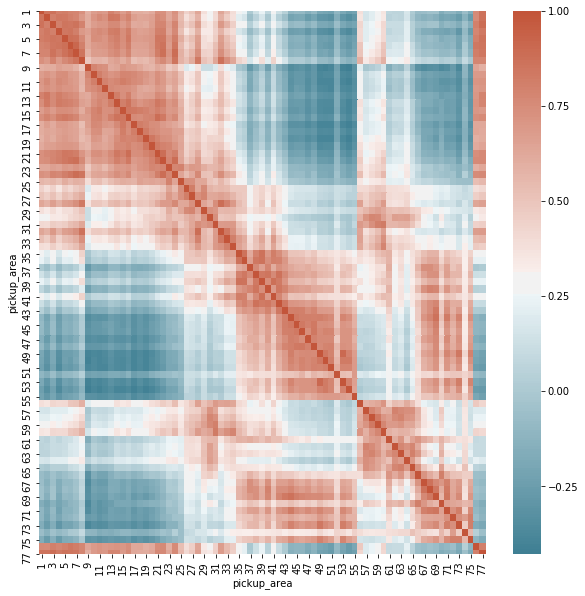

In [0]:
kendall_corr = ordered_pivot.corr(method='kendall')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(kendall_corr, ax=ax, cmap=sns.diverging_palette(220, 20, n=200))

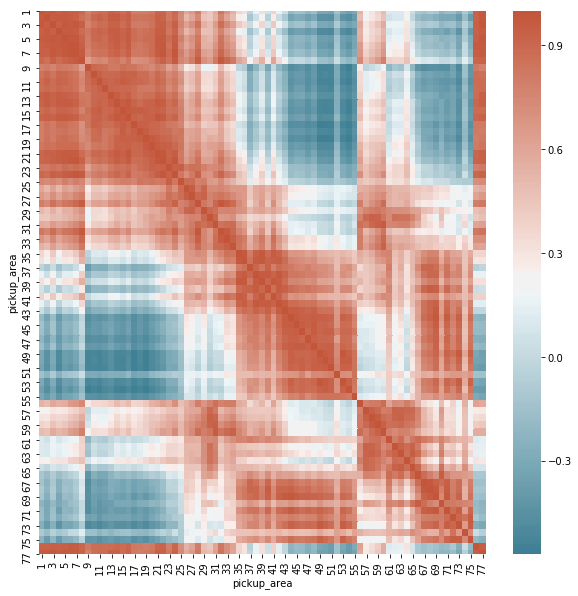

In [0]:
spearman_corr = ordered_pivot.corr(method='spearman')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(spearman_corr, ax=ax, cmap=sns.diverging_palette(220, 20, n=200))

In [0]:
test_count_df_lst = []
folder = "/content/drive/My Drive/Math ML project/tnp_pagerank/testing_data"
for csv in os.listdir(folder):
  one_csv_df = pd.read_csv(f"{folder}/{csv}", index_col=0)
  test_count_df_lst.append(one_csv_df)
total_test_count_df = pd.concat(test_count_df_lst)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [0]:
raw_test_counts = total_test_count_df.groupby('dropoff_community_area').size()

In [0]:
test_proportion = raw_test_counts / raw_test_counts.sum()

In [0]:
corr_df = test_proportion.reset_index().rename(columns={0: 'actual_dropoff_count'})
corr_df

,dropoff_community_area,actual_dropoff_count
0,1.0,0.010419
1,2.0,0.008285
2,3.0,0.020801
3,4.0,0.011683
4,5.0,0.012771
...,...,...
72,73.0,0.002703
73,74.0,0.000770
74,75.0,0.001952
75,76.0,0.049892


In [0]:
d_vals = [(0.01, 'd0.01'), (0.15, 'd0.15'), (0.30, 'd0.3'), (0.5, 'd0.5'), (0.75, 'd0.75'), (0.85, 'd0.85'), (0.99, 'd0.99')]
corr_df = test_proportion.reset_index().rename(columns={0: 'actual_dropoff_count_weighted'})
for value, name in d_vals:
  output_vec = pagerank(norm_adj_mat, value)
  corr_df[name] = pd.Series(output_vec[:, 0])
  weighted_correlations = corr_df.corr(method='kendall')['actual_dropoff_count_weighted'][2:]

In [0]:
d_vals = [(0.01, 'd0.01'), (0.15, 'd0.15'), (0.30, 'd0.3'), (0.5, 'd0.5'), (0.75, 'd0.75'), (0.85, 'd0.85'), (0.99, 'd0.99')]
corr_df = test_proportion.reset_index().rename(columns={0: 'actual_dropoff_count_normal'})
for value, name in d_vals:
  output_vec = pagerank(redo_norm_pg_mat, value)
  corr_df[name] = pd.Series(output_vec[:, 0])
  normal_correlations = corr_df.corr(method='kendall')['actual_dropoff_count_normal'][2:]

In [0]:
correlations_df = pd.DataFrame([normal_correlations, weighted_correlations]).T.reset_index()
correlations_df

,index,actual_dropoff_count_normal,actual_dropoff_count_weighted
0,d0.01,0.594124,0.641600
1,d0.15,0.593399,0.654589
2,d0.3,0.594144,0.670313
3,d0.5,0.590524,0.705862
4,d0.75,0.593399,0.773543
5,d0.85,0.592675,0.827551
6,d0.99,0.588351,0.949923


In [0]:
correlations_df.rename(columns={'index': 'd value',
                                'actual_dropoff_count_normal': 'Regular PageRank',
                                'actual_dropoff_count_weighted': 'Weighted PageRank'},
                       inplace=True)
correlations_df.set_index('d value').T.drop(columns=['d0.01', 'd0.3', 'd0.75', 'd0.99']). \
                                rename(columns={'d0.15': 0.15, 'd0.5': 0.5, 'd0.85': 0.85})

d value,0.15,0.50,0.85
Regular PageRank,0.593399,0.590524,0.592675
Weighted PageRank,0.654589,0.705862,0.827551


In [0]:
melted = pd.melt(correlations_df, id_vars='index')
melted['index'] = melted['index'].str[1:]
melted

,index,variable,value
0,0.01,actual_dropoff_count_normal,0.594124
1,0.15,actual_dropoff_count_normal,0.593399
2,0.3,actual_dropoff_count_normal,0.594144
3,0.5,actual_dropoff_count_normal,0.590524
4,0.75,actual_dropoff_count_normal,0.593399
5,0.85,actual_dropoff_count_normal,0.592675
6,0.99,actual_dropoff_count_normal,0.588351
7,0.01,actual_dropoff_count_weighted,0.641600
8,0.15,actual_dropoff_count_weighted,0.654589
9,0.3,actual_dropoff_count_weighted,0.670313


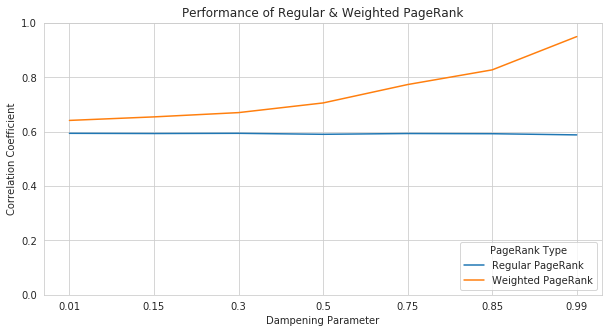

In [0]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylim((0, 1))
ax.set_title("Performance of Regular & Weighted PageRank")
sns.lineplot(x="index", y="value", hue="variable", data=melted, ax=ax)
plt.legend(title="PageRank Type", loc='lower right', labels=['Regular PageRank',
                                                             'Weighted PageRank'])
ax.set(xlabel='Dampening Parameter', ylabel='Correlation Coefficient')
sns.set_style("whitegrid")
plt.show()

In [0]:
weighted_stats = pd.DataFrame(columns=['dampening_val', 'std_dev', 'min', 'max'])
for value, name in d_vals:
  output_vec = pagerank(norm_adj_mat, value)
  weighted_stats.loc[len(weighted_stats)] = [value, np.std(output_vec), np.amin(output_vec), np.amax(output_vec)]
weighted_stats['pr_type'] = 'weighted'

In [0]:
normal_stats = pd.DataFrame(columns=['dampening_val', 'std_dev', 'min', 'max'])
for value, name in d_vals:
  output_vec = pagerank(redo_norm_pg_mat, value)
  normal_stats.loc[len(normal_stats)] = [value, np.std(output_vec), np.amin(output_vec), np.amax(output_vec)]
normal_stats['pr_type'] = 'normal'

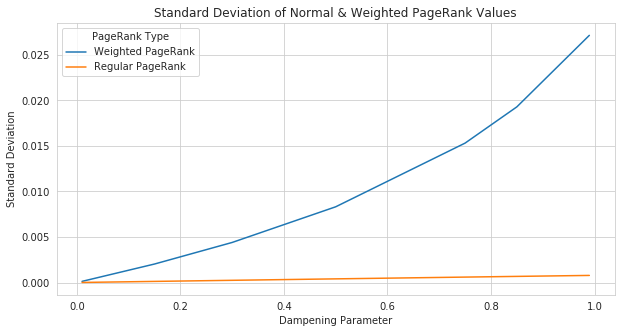

In [0]:
total_stats = pd.concat([weighted_stats, normal_stats])
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Standard Deviation of Normal & Weighted PageRank Values")
sns.set_style("whitegrid")
sns.lineplot(x="dampening_val", y="std_dev", hue="pr_type", data=total_stats, ax=ax)
plt.legend(title="PageRank Type", labels=['Weighted PageRank', 'Regular PageRank'])
ax.set(xlabel='Dampening Parameter', ylabel='Standard Deviation')
plt.show()

In [0]:
total_stats

,dampening_val,std_dev,min,max,pr_type
0,0.01,0.000127,0.012877,0.013637,weighted
1,0.15,0.002032,0.011326,0.023652,weighted
2,0.30,0.004400,0.009630,0.036678,weighted
3,0.50,0.008316,0.007291,0.059203,weighted
4,0.75,0.015311,0.004147,0.101112,weighted
5,0.85,0.019292,0.002758,0.125327,weighted
6,1.00,0.027863,0.000186,0.177264,weighted
0,0.01,0.000007,0.012941,0.012987,normal
1,0.15,0.000111,0.012297,0.012974,normal
2,0.30,0.000219,0.011585,0.012924,normal


In [0]:
weighted_comm_names = ordered_pivot.rename(columns=comm_names_dict)
weighted_comm_names = weighted_comm_names.T.rename(columns=comm_names_dict).T

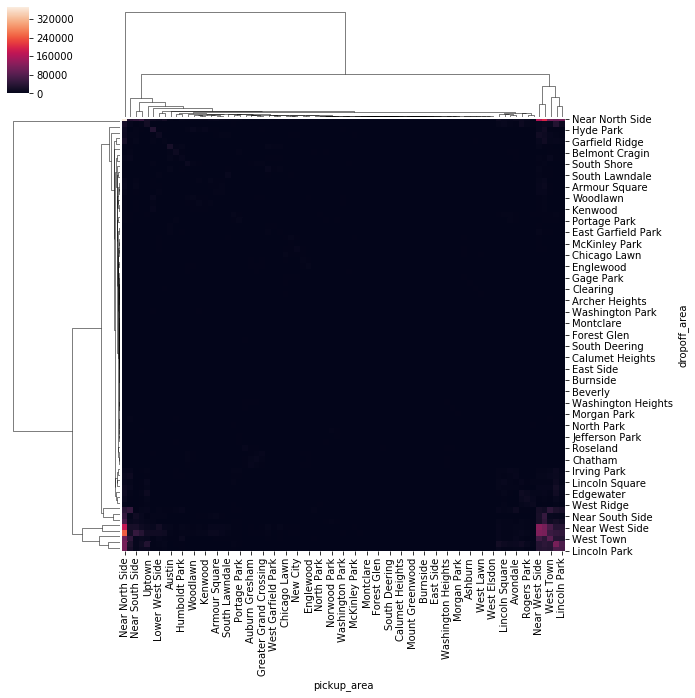

In [0]:
sns.clustermap(weighted_comm_names)

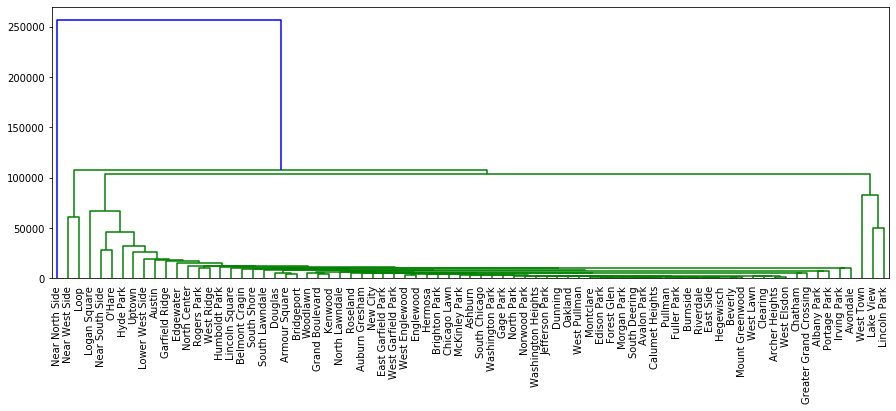

In [0]:
Z = hierarchy.linkage(weighted_comm_names.T, 'single')
plt.figure(figsize=(15, 5))
dn = hierarchy.dendrogram(Z, labels=weighted_comm_names.T.columns, leaf_font_size=10)

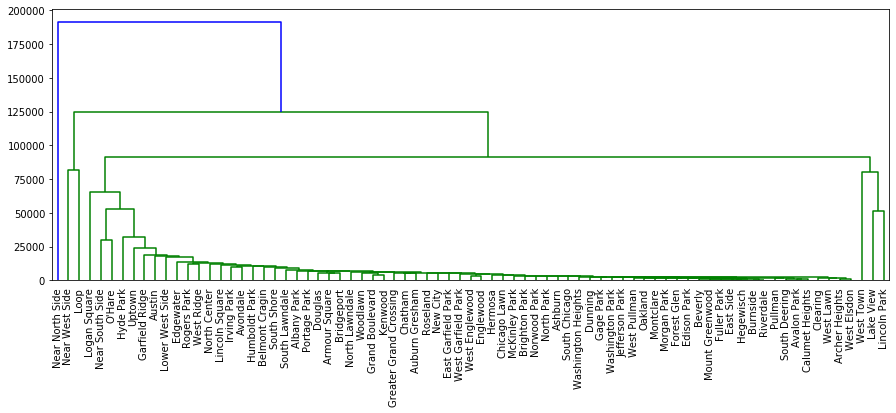

In [0]:
Z = hierarchy.linkage(weighted_comm_names, 'single')
plt.figure(figsize=(15, 5))
dn = hierarchy.dendrogram(Z, labels=weighted_comm_names.columns, leaf_font_size=10)